# PCA for Source Separation of Ventilation and Cardiovascular Activity in Electrical Impedance Tomography (EIT)

## Introduction
In this exercise we use PCA for processing image sequences of thoracic electrical impedance tomography (EIT) signals. EIT is a non-invasive, radiation-free imaging modality which uses small alternating currents to measure bioimpedance of the thorax [1]. These measurements are then converted into image sequences of thoracic impedance changes representing ventilation (i.e., air exchange in the lungs) and cardiovascular activity (e.g., heart movement or blood volume changes in heart and lungs). 

In order to analyze these data it is important to properly separate ventilation and cardiovascular activity. Besides common techniques such as frequency filtering or ECG-triggered averaging, PCA can be used for separating these two sources of signals.
The present example uses the method proposed by Deibele et al. [2] for which the block diagram is shown below:

<img src="FlowChart_Deibele.png">


## References

[1] I. Frerichs et al., “Chest electrical impedance tomography examination, data analysis, terminology, clinical use and recommendations: consensus statement of the TRanslational EIT developmeNt stuDy group,” Thorax, vol. 72, no. 1, pp. 83–93, Jan. 2017, doi: [10.1136/thoraxjnl-2016-208357](https://dx.doi.org/10.1136/thoraxjnl-2016-208357).

[2] J. M. Deibele, H. Luepschen, and S. Leonhardt, “Dynamic separation of pulmonary and cardiac changes in electrical impedance tomography,” Physiological Measurement, vol. 29, no. 6, pp. S1–S14, Jun. 2008, doi: [10.1088/0967-3334/29/6/S01](https://dx.doi.org/10.1088/0967-3334/29/6/S01).



## Exercise Questions
Please provide your answers directly below the questions.

---

1) Determine the frequency of the ventilation activity (i.e., the respiratory rate), both expressed in `Hz` and `beats/min`.

```
Your answer: around 20 bpm, 0.33 Hz
```
---

2) Determine the frequency of the cardiovascular activity, both expressed in `Hz` and `beats/min`.

```
Your answer: around 58 bpm, 1 Hz
```
---

3) Determine the follwing three values:

- i) the maximal amplitude of ventilation activity; 
- ii) the maximal amplitude of cardiovascular activity; and 
- iii) the ratio between i) and ii), i.e., ventilation vs cardiovascular activity. 

```
Your answer:
i) 0.007
ii) 0.0014
iii) cAmp/vAmp = 0.2
```
---

4) Determine the eigenvalues of the first three principal components resulting from the first PCA (hint, see line **XXX**).

```
Your answer: [107.58688656   2.11148888   0.80315244]
```
---

5) Similar to 4), determine the two most dominant frequencies for the first three principal components (you must obtain 6 values, 2 frequencies for each of the 3 PCA components).

For all 3 PCA components, which one is rather related to ventilation or cardiovascular activity?

```
Your answer:
Below we plot the spectrogram of the each of the principal components. This allows us to see the main contributing frequencies as they change with time, and can allow more insight than a simple fft or spectrum taken over the whole signal.
1st PC [0.3, -] Hz --> respiration
2nd PC: [0.3, 1] Hz --> respiration and cardiac
3rd PC [1, -] Hz --> cardiac
```
---

6) The three example signals (Regions A to C: **green, blue, red**) of cardiovascular activity show the impedance change over time. 
Can you guess the underlying anatomical structure for each of the three example signals (Regions A to C: **green, blue, red**).

```
Your answer: green is the heart because it has the highest cardiac activity (looking at the signal amplitude at the corresponding cardiac frequency). blue and red are lungs as they have a lower amplitude cardiac signal and they are in phase.
```

7) *Bonus Question* (not graded) Can you detect the QRS peaks (e.g., using [`biosppy.signals.ecg.hamilton_segmenter`](https://biosppy.readthedocs.io/en/latest/biosppy.signals.html#biosppy.signals.ecg.hamilton_segmenter)) on the ECG signal (see variable `ecg`) and plot them together with the cardiovascular EIT activity?

```
Your answer: yes of course
```



In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import filtfilt, butter
from scipy.linalg import eigh
from biosppy.signals.ecg import hamilton_segmenter

import matplotlib.pyplot as plt
# enable interactive plotting
%matplotlib widget

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)  # initiate notebook for offline plot

In [2]:
# load data
data = loadmat('EIT_Data.mat')
t = data['tEit'].flatten()[data['IdxRange'].flatten().astype(bool)]
fs = 1/np.median(np.diff(t))
imgs_eit = data['Imgs']
b, a = butter(4, np.asarray([0.1, 12])/(fs/2), btype='bandpass')
imgs_eit = filtfilt(b, a, imgs_eit, axis=-1)
imgs_eit *= 1E3  # adapt scaling for plotting

# ECG data to be used for bonus question
ecg = {'time': data['Ecg'][0][0][2], 'value': data['Ecg'][0][0][1], 'fs': data['Ecg'][0][0][3]}
ecg_range = (ecg['time'] > t[0]) & (ecg['time'] < t[-1])
ecg['time'] = ecg['time'][ecg_range]
ecg['value'] = ecg['value'][ecg_range]

# force all timings to start at zero
t -= t[0]
ecg['time'] -= ecg['time'][0]

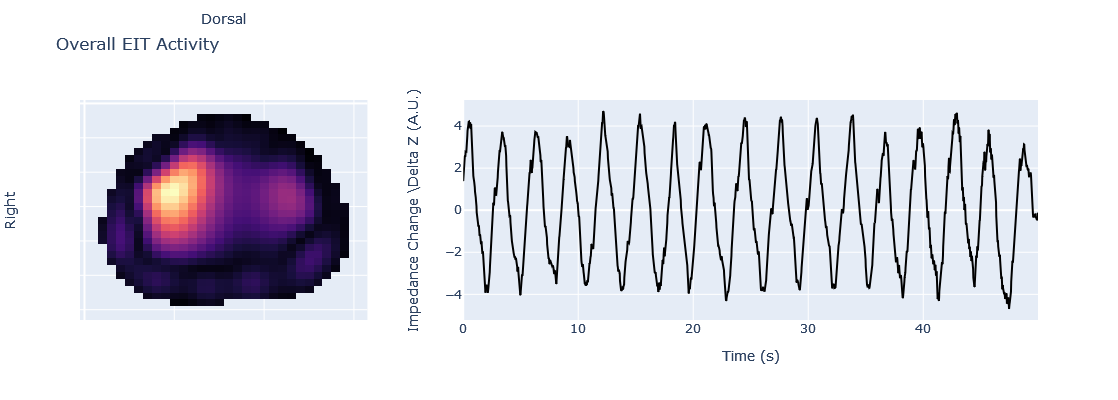

In [3]:
# plot input data
fig = make_subplots(rows=1, cols=2, column_widths=[1, 2])
fig.update_layout(width=950, height=400)

fig.add_trace(go.Heatmap(z=np.std(imgs_eit, axis=-1), zmin=0, 
                         showscale=False, colorscale='magma'), row=1, col=1)
fig.update_yaxes(title='Right', showticklabels=False, autorange="reversed", row=1, col=1)
fig.update_xaxes(title='Dorsal', showticklabels=False, row=1, col=1)
fig.update_layout(title='Overall EIT Activity')

fig.add_trace(go.Scatter(x=t, y=np.nansum(imgs_eit, axis=(0, 1)), 
                         name='Overall Sum Signal', line_color='black'), row=1, col=2)
fig.update_xaxes(title='Time (s)', row=1, col=2)
fig.update_yaxes(title='Impedance Change \Delta Z (A.U.)', row=1, col=2)


In [4]:
def compute_principal_components(X):
    # perform PCA and compute principal components (pc) and eigenvalues of X
    A = np.dot(X.transpose(), X)  # covariance matrix
    [eigenvalues, eigenvectors] = eigh(A)
    pc = np.dot(X, eigenvectors)
    return pc, eigenvalues

def estimate_cardiac_frequency(s, fs):
    sign_cardiac = np.sign(s)
    # find where zero crossings occured
    index = np.where(np.diff(sign_cardiac) == 2)[0]
    # interpolate to a sub-sample resolution
    pos = index + s[index + 1] / (s[index + 1] - s[index])
    # interpolate RR interval values
    rr = np.diff(pos) / fs
    return 1/np.median(rr)

def lms(A, B):
    if B.ndim == 1:
        B = np.asmatrix(B).transpose()
    tmp = np.linalg.solve(np.dot(B.transpose(), B), B.transpose())
    return np.dot(np.dot(B, tmp), A)

# separate ventilation and cardiovascular activity using PCA
# according to the algorithm by Deibele et al., PhysMeas, 2008
# https://dx.doi.org/10.1088/0967-3334/29/6/S01
imgs_tmp = np.reshape(imgs_eit, [-1, imgs_eit.shape[-1]])
are_valid_pixels = np.all(~np.isnan(imgs_tmp), 1)
X = imgs_tmp[are_valid_pixels, :].transpose()

# first approximation (see block diagram)
X = X - np.repeat(np.reshape(np.mean(X, 0), [1, -1]), X.shape[0], 0)
PC1, lambda1 = compute_principal_components(X)
Bv = PC1[:, -1]
Xv_ = lms(X, Bv)
Xc_ = X - Xv_

# second approximation (see block diagram)
Xc_ = Xc_ - np.repeat(np.reshape(np.mean(Xc_, 0), [1, -1]), Xc_.shape[0], 0)
b, a = butter(6, np.asarray([0.92, 4.6])/(fs/2), btype='bandpass')
Xc_bp = filtfilt(b, a, Xc_, axis=0)
PC2, lambda2 = compute_principal_components(Xc_bp)
Bc_ = PC2[:, -2:]
fc = estimate_cardiac_frequency(Bc_[:, 0], fs)

# create cardiac template functions
Bc = np.hstack((Bc_, np.roll(Bc_, int(fs/fc/3), 0),
                np.roll(Bc_, -int(fs/fc/3), 0)))
Xc1 = lms(Xc_, Bc)
Xc2 = lms(Xv_, Bc)
Xc = (Xc1 + Xc2).transpose()
Xv = (Xv_ - Xc2).transpose()

# cardiovascular activity
imgs_card = np.full(imgs_tmp.shape, np.nan)
imgs_card[are_valid_pixels, :] = Xc
imgs_card = imgs_card.reshape(imgs_eit.shape)
# ventilation activity
imgs_vent = np.full(imgs_tmp.shape, np.nan)
imgs_vent[are_valid_pixels, :] = Xv
imgs_vent = imgs_vent.reshape(imgs_eit.shape)

[107.58688656   2.11148888   0.80315244]


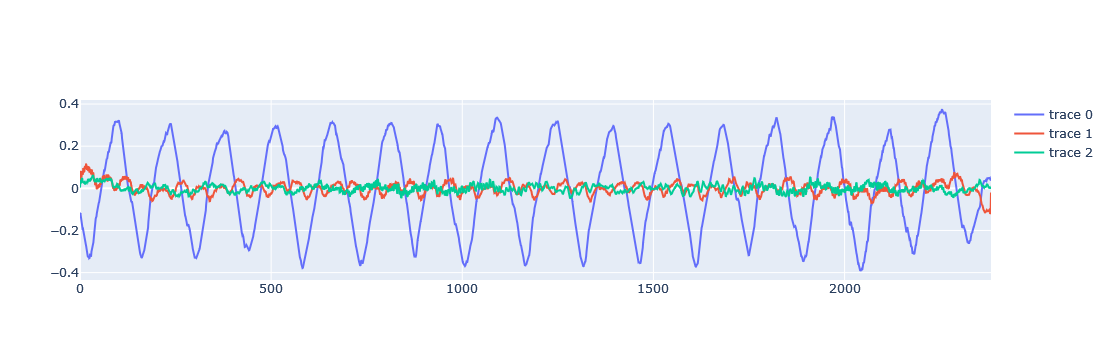

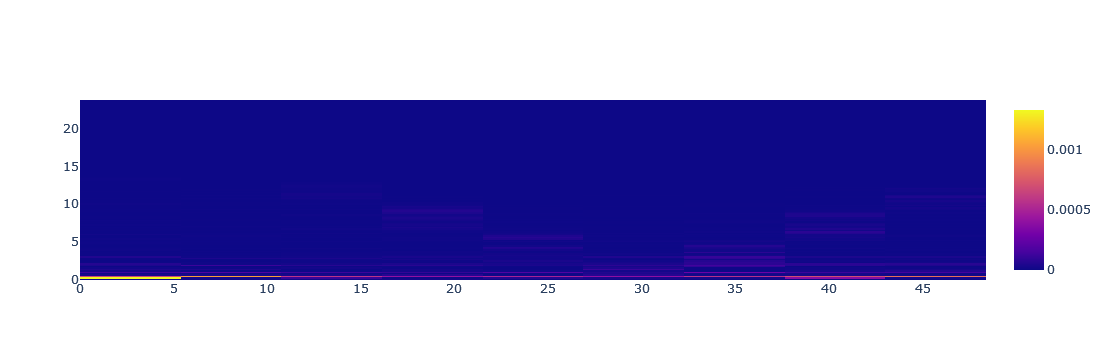

In [5]:
print(lambda1[::-1][:3])

fig = go.Figure()
fig.add_trace(go.Scatter(y=PC1[:, -1]))
fig.add_trace(go.Scatter(y=PC1[:, -2]))
fig.add_trace(go.Scatter(y=PC1[:, -3]))
fig.show()

from scipy.signal import spectrogram

f, t_spec, Sxx = spectrogram(PC1[:, -3], fs=fs, nperseg=256, noverlap=0.9)
fig = go.Figure()
fig.add_trace(go.Heatmap(y=f, x=t_spec, z=Sxx))
fig.show()


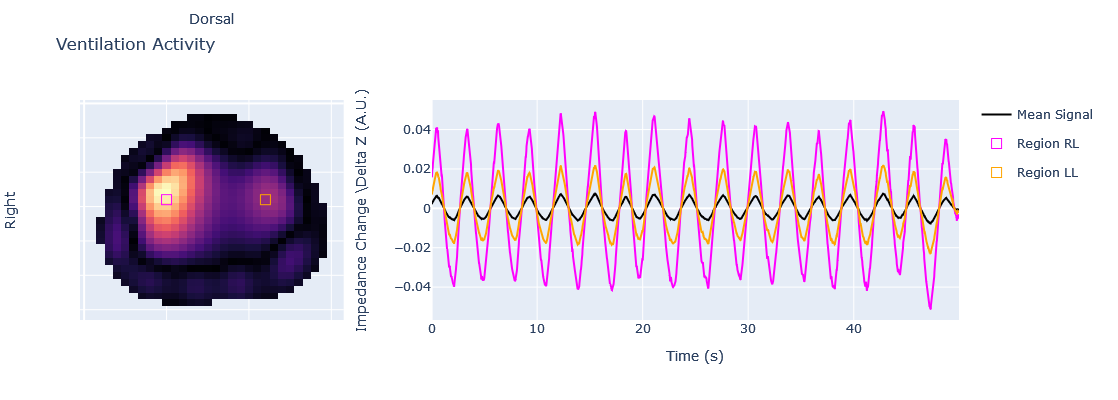

In [6]:
# plot ventilation acticity
fig = make_subplots(rows=1, cols=2, column_widths=[1, 2])
fig.update_layout(width=950, height=400)

fig.add_trace(go.Heatmap(z=np.std(imgs_vent, axis=-1), zmin=0, 
                         showscale=False, colorscale='magma'), row=1, col=1)
fig.update_yaxes(title='Right', showticklabels=False, autorange="reversed", row=1, col=1)
fig.update_xaxes(title='Dorsal', showticklabels=False, row=1, col=1)
fig.update_layout(title='Ventilation Activity')

fig.add_trace(go.Scatter(x=t, y=np.nanmean(imgs_vent, axis=(0, 1)), 
                         name='Mean Signal', line_color='black'), row=1, col=2)
fig.update_xaxes(title='Time (s)', row=1, col=2)
fig.update_yaxes(title='Impedance Change \Delta Z (A.U.)', row=1, col=2)

# add example signals in ??? regions
regions = {'Region RL': ([10, 14], 'magenta'), 'Region LL': ([22, 14], 'orange')}
for reg, tmp in regions.items():
    fig.add_scatter(x=[tmp[0][0]], y=[tmp[0][1]], mode='markers', marker_symbol='square-open', 
                    marker_size=10, legendgroup=reg, marker_color=tmp[1], name=reg, row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=imgs_vent[tmp[0][1], tmp[0][0], :], legendgroup=reg, 
                             showlegend=False, name=reg, line_color=tmp[1]), row=1, col=2) 
    
fig.show()

In [7]:
# plot cardiovascular acticity
fig = make_subplots(rows=1, cols=2, column_widths=[1, 2])
fig.update_layout(width=950, height=400)

fig.add_trace(go.Heatmap(z=np.std(imgs_card, axis=-1), zmin=0, 
                         showscale=False, colorscale='magma'), row=1, col=1)
fig.update_yaxes(title='Right', showticklabels=False, autorange="reversed", row=1, col=1)
fig.update_xaxes(title='Dorsal', showticklabels=False, row=1, col=1)
fig.update_layout(title='Cardiovascular Activity')

fig.add_trace(go.Scatter(x=t, y=np.nanmean(imgs_card, axis=(0, 1)), 
                         name='Mean Signal', line_color='black'), row=1, col=2)
fig.update_xaxes(title='Time (s)', row=1, col=2)
fig.update_yaxes(title='Impedance Change \Delta Z (A.U.)', row=1, col=2)

# add three example signals in ??? regions
regions = {'Region A': ([18, 9], 'green'), 'Region B': ([10, 15], 'blue'), 'Region C': ([23, 15], 'red')}
for reg, tmp in regions.items():
    fig.add_scatter(x=[tmp[0][0]], y=[tmp[0][1]], mode='markers', marker_symbol='square-open', 
                    marker_size=10, legendgroup=reg, marker_color=tmp[1], name=reg, row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=imgs_card[tmp[0][1], tmp[0][0], :], legendgroup=reg, 
                             showlegend=False, name=reg, line_color=tmp[1]), row=1, col=2)    
fig.show()

In [8]:
0.0014 / 0.007

0.19999999999999998

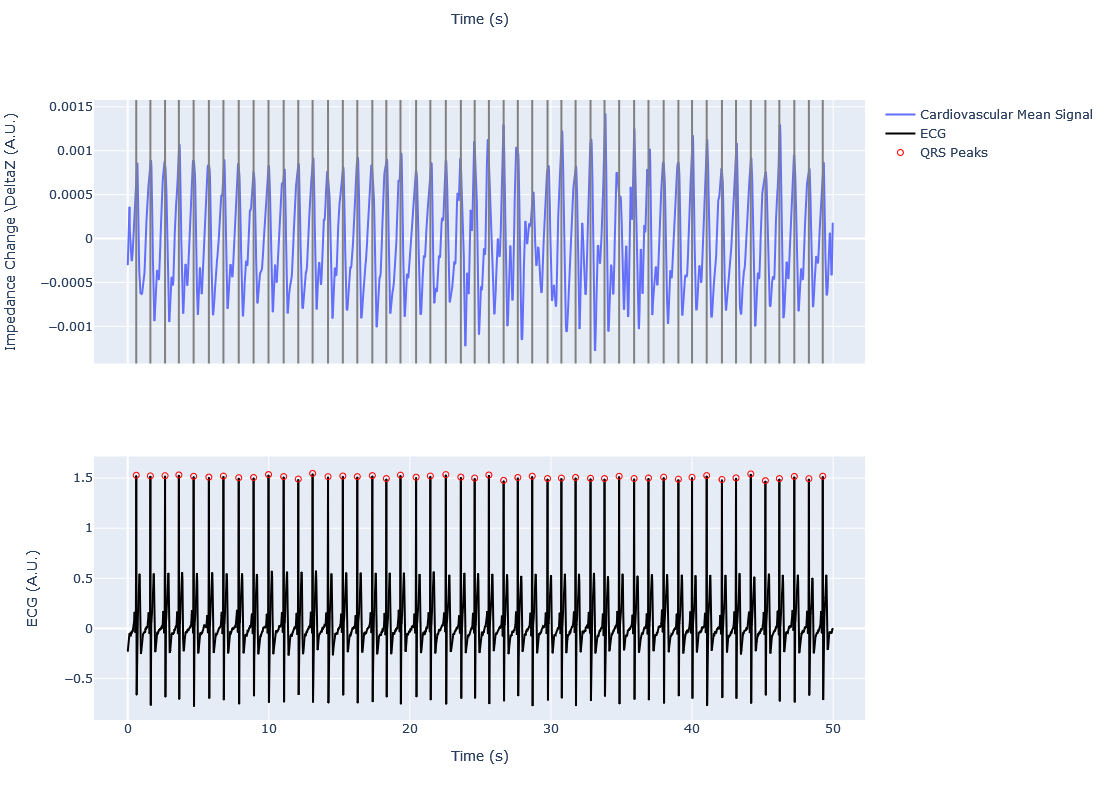

In [9]:
# detect R-peaks in ECG
rpeaks = hamilton_segmenter(ecg['value'], ecg['fs'])
tr = ecg['time'][rpeaks]

# plot
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.update_layout(width=950, height=800)

fig.add_trace(go.Scatter(x=t, y=np.nanmean(imgs_card, axis=(0, 1)),
                        name='Cardiovascular Mean Signal'), row=1, col=1)
fig.update_yaxes(title='Impedance Change \DeltaZ (A.U.)', row=1, col=1)
fig.update_xaxes(title='Time (s)', row=1, col=1)
for tr_peak in tr:
    fig.add_vline(x=tr_peak, line_color='grey')

fig.add_trace(go.Scatter(x=ecg['time'], y=ecg['value'], name='ECG', line_color='black'), row=2, col=1)
fig.add_trace(go.Scatter(x=ecg['time'][rpeaks], y=ecg['value'][rpeaks], mode='markers', 
                         marker_color='red', marker_symbol='circle-open', name='QRS Peaks'), row=2, col=1)
fig.update_yaxes(title='ECG (A.U.)', row=2, col=1)
fig.update_xaxes(title='Time (s)', row=2, col=1)
